In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns;sns.set_style("white")
from neo.io import PickleIO
from lib.analysis import compute_rates
from lib.util import Results
from lib.analysis import calculate_activity, fetch_results

In [13]:
n_classes = np.array([10])# np.load("results/n_classes.npy")
version_names = [ 
   #"muted_supervised",
   # "PO_supervised",
    "unmuted_supervised",
    "muted_supervised"
]

class Version:
    def __init__(self, name, n):
        self.name = name
        self.n_class = n

    def tag(self):
        return f"{self.name}_{self.n_class}" 
    
    def __repr__(self):
        return self.tag()
    
    def __str__(self):
        return self.tag()


versions = [ Version(name,n) for n in n_classes for name in version_names ]

params = [ np.load(f"results/{v.tag()}_params.npz") for v in versions ]
pvs = list(zip(params,versions))
data = [ fetch_results(v.tag(), p) for p,v in pvs ]
ikc_data = [ fetch_results(v.tag(), p, 'ikc') for p,v in pvs ]
pn_data = [ fetch_results(v.tag(), p, 'pn') for p,v in pvs ]

In [14]:
print(versions)

[unmuted_supervised_10, muted_supervised_10]


In [15]:
for i,v in enumerate(versions):
    print(f"{v} - n_runs:", params[i]['runs'])

unmuted_supervised_10 - n_runs: 20
muted_supervised_10 - n_runs: 20


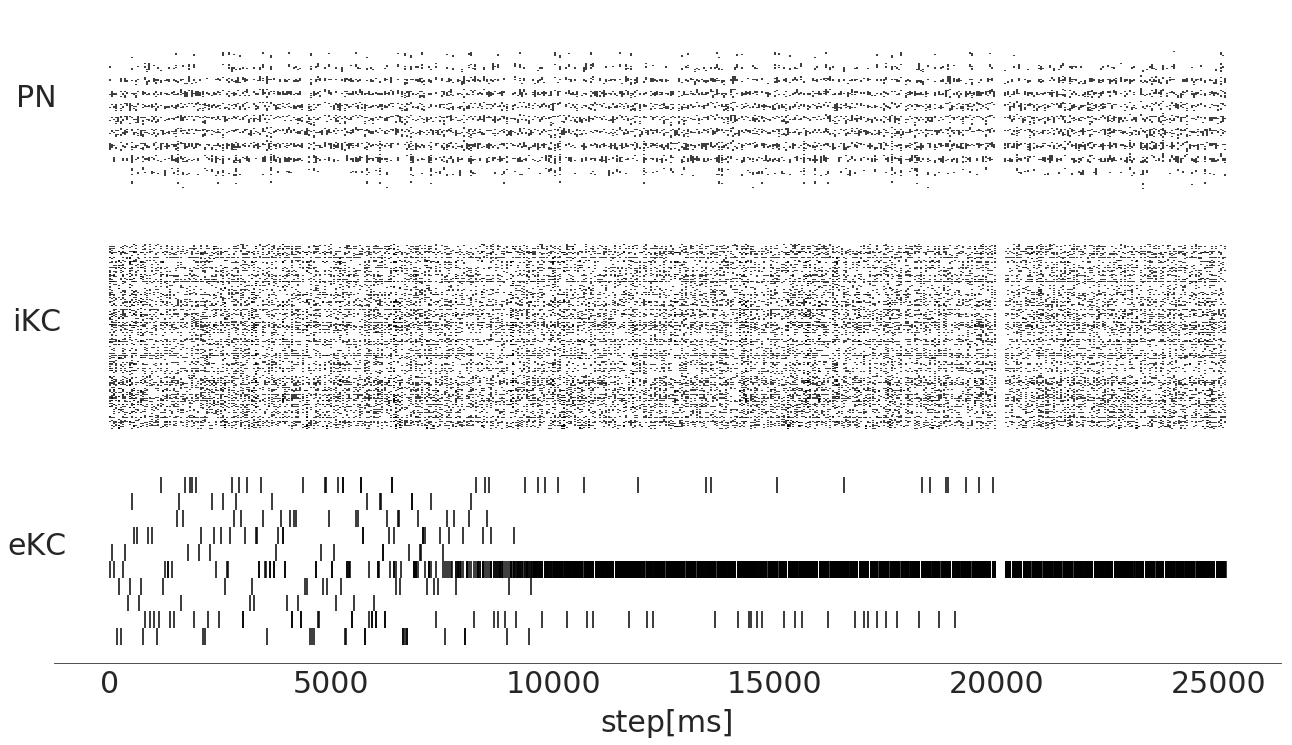

In [26]:
v_ix = 0
run_ix = 0

sns.set_style("white")
plt.rcParams.update({
    'font.size': 30
})
fig, axs = plt.subplots(3, figsize=(22,12), sharex=True)
plt.subplots_adjust(hspace=0.1)
axs = np.atleast_1d(axs).flatten()


axs[0].eventplot(pn_data[v_ix][run_ix], colors='k')
axs[1].eventplot(ikc_data[v_ix][run_ix], colors='k')
axs[2].eventplot(data[v_ix][run_ix], colors='k')

axs[-1].set_xlabel("step[ms]", labelpad=10)

for ax in fig.get_axes():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticklabels([])

axs[1].spines['bottom'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)

axs[0].set_ylabel("PN", rotation=0, labelpad=10)
axs[1].set_ylabel("iKC", rotation=0, labelpad=10)
axs[2].set_ylabel("eKC", rotation=0, labelpad=10)

plt.savefig(f"img/raster-{versions[v_ix]}.png")
plt.show()

In [8]:
# Compute firing rates
rates = [ compute_rates(runs,params[i]) for i,runs in enumerate(data) ]

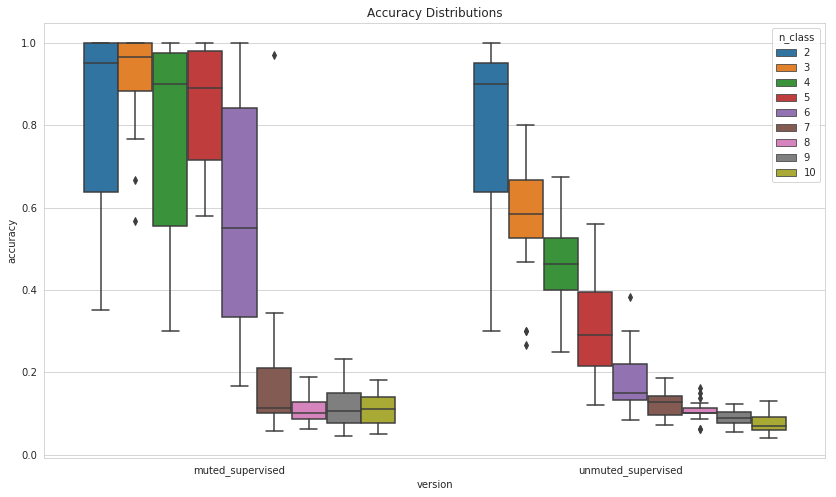

In [10]:
def get_pred(trace, n_class):
    step = int(len(trace) / n_class)
    
    def pred(i,time_slice):
        return time_slice.reshape(n_class,step).sum(axis=-1).argmax()
    
    return np.array([ pred(i,tslice) for i,tslice in enumerate(trace.T) ])
    
def eval_acc(trace, labels, n_class):
    pred = get_pred(trace, n_class)
    return np.mean([ y == yh for y,yh in zip(labels,pred) ], dtype='float')


accs = pd.DataFrame()
for i,ver in enumerate(versions):
    runs = rates[i]
    labelset = params[i]['labels']
    n_class = ver.n_class
    for run,labels in zip(runs,labelset):
        acc = eval_acc(run,labels,n_class)
        accs = accs.append(pd.DataFrame({
            "version": [ver.name], "accuracy": acc, "n_class": [n_class]
        }))

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14,8))
sns.boxplot(x='version', y='accuracy', hue='n_class', data=accs, ax=ax)
ax.set_title("Accuracy Distributions")
plt.savefig("accuracy_boxplot_by_class.png")
plt.show()

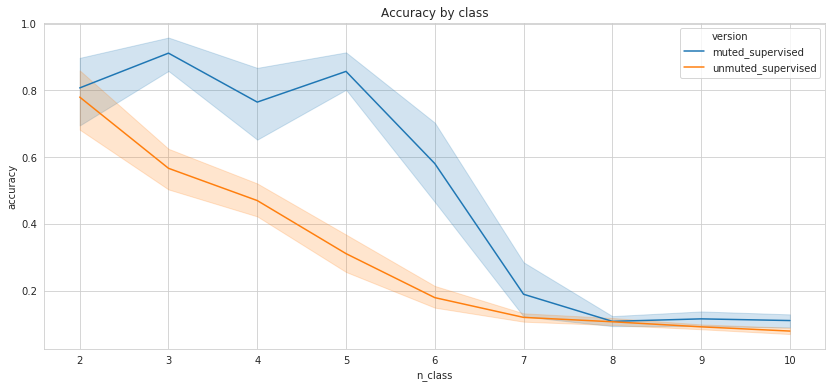

In [14]:
fig, ax = plt.subplots(figsize=(14,6))
sns.lineplot(x='n_class', y='accuracy', hue='version', data=accs, ax=ax)

ax.set_title("Accuracy by class")

plt.savefig("accuracy_trace_by_class.png")
plt.show()

## Weight Analysis

In [15]:
weight_logs = [ np.load(f"results/{version.tag()}/weight_log.npy") for version in versions ]

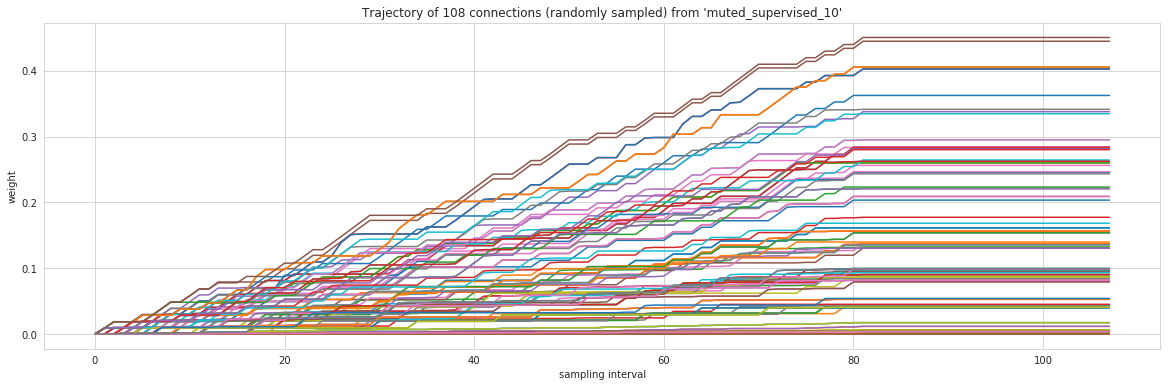

In [20]:
v_ix = 16
weights = weight_logs[0]

n_weights = min(500, len(weights))

sample = np.random.choice(len(weights)-1, n_weights)
selected = weights[:,sample]

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(selected)
ax.set_ylabel("weight")
ax.set_xlabel("sampling interval")
ax.set_title(f"Trajectory of {n_weights} connections (randomly sampled) from '{versions[v_ix]}'")
plt.savefig("weight_trajectory.png")
plt.show()

## Change in $A_+$

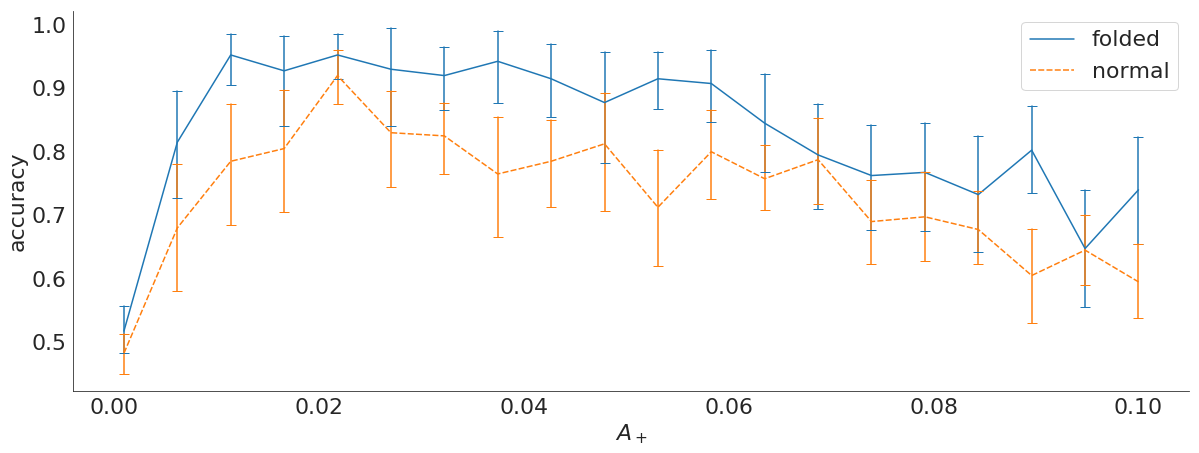

In [14]:
ap_range = np.load("results/ap_range.npy")

df = pd.DataFrame({})

for ap in ap_range:
    accs = pd.read_csv(f"results/acc_AP={ap}.csv")
    accs[r'$A_+$'] = ap
    df = df.append(accs)

df = df.replace({'muted_supervised_2': 'folded', 'unmuted_supervised_2': 'normal'})

plt.rcParams.update({
    'font.size': 22
})
fig, ax = plt.subplots(figsize=(20,7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pt = sns.lineplot(x=r"$A_+$", y='accuracy', hue='version', style='version', data=df, ax=ax, 
             err_style='bars', err_kws={'capsize': 5})

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])

plt.savefig("img/aplus_tune.png")
plt.show()

In [27]:
a = np.load("results/ap_range.npy")
rng

array([0.001     , 0.00621053, 0.01142105, 0.01663158, 0.02184211,
       0.02705263, 0.03226316, 0.03747368, 0.04268421, 0.04789474,
       0.05310526, 0.05831579, 0.06352632, 0.06873684, 0.07394737,
       0.07915789, 0.08436842, 0.08957895, 0.09478947, 0.1       ])